In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
test_preds_loc = '/Users/user/repos/gz-evo/results/baselines/regression/convnext_base_534895718/test_predictions.csv'

df = pd.read_csv(test_preds_loc)
df.head()

,smooth-or-featured-dr12_smooth_fraction,smooth-or-featured-dr12_featured-or-disk_fraction,smooth-or-featured-dr12_artifact_fraction,disk-edge-on-dr12_yes_fraction,disk-edge-on-dr12_no_fraction,has-spiral-arms-dr12_yes_fraction,has-spiral-arms-dr12_no_fraction,bar-dr12_yes_fraction,bar-dr12_no_fraction,bulge-size-dr12_dominant_fraction,...,spiral-arm-count-hubble_cant-tell_fraction,bulge-size-hubble_none_fraction,bulge-size-hubble_just-noticeable_fraction,bulge-size-hubble_obvious_fraction,bulge-size-hubble_dominant_fraction,galaxy-symmetrical-hubble_yes_fraction,galaxy-symmetrical-hubble_no_fraction,clumps-embedded-larger-object-hubble_yes_fraction,clumps-embedded-larger-object-hubble_no_fraction,id_str
0,0.839651,0.030257,0.130092,0.147126,0.852874,0.029732,0.970268,0.048137,0.951863,0.446510,...,0.528138,0.049787,0.106615,0.268227,0.575371,0.816297,0.183703,0.584212,0.415788,132995_2282
1,0.864404,0.061018,0.074578,0.128252,0.871748,0.190686,0.809314,0.085099,0.914901,0.065167,...,0.616765,0.212743,0.582760,0.129240,0.075256,0.829216,0.170784,0.842539,0.157460,341184_4266
2,0.820206,0.075108,0.104686,0.124319,0.875681,0.036220,0.963780,0.043366,0.956634,0.506814,...,0.625111,0.017312,0.095248,0.519452,0.367987,0.817574,0.182426,0.838614,0.161386,524482bc3ae74054bf00ff61.jpg
3,0.292171,0.638160,0.069668,0.067948,0.932052,0.800380,0.199620,0.246080,0.753920,0.171189,...,0.238828,0.008637,0.322217,0.581753,0.087393,0.644519,0.355481,0.821044,0.178956,430406_4138
4,0.551581,0.262304,0.186115,0.524943,0.475057,0.066934,0.933066,0.058265,0.941735,0.056957,...,0.413424,0.477349,0.325445,0.153130,0.044076,0.233706,0.766294,0.773901,0.226099,524482bc3ae74054bf00a91c.jpg


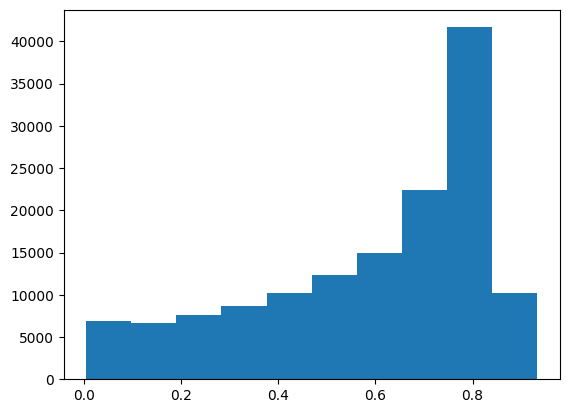

In [5]:
_ = plt.hist(df['smooth-or-featured-dr5_smooth_fraction'])

In [6]:
import datasets 

test_dataset = datasets.load_dataset("mwalmsley/gz_evo", name='default', split='test', features=df.columns.tolist())

/Users/user/mambaforge/envs/zoobot39_dev/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm

In [ ]:
test_dataset.set_format('pandas')

In [ ]:
assert False

In [ ]:
# merge with predictions, using _vol and _ml suffixes to avoid conflicts
df = pd.merge(test_dataset.data, df, on='id_str', how='inner', validate='1:1', suffixes=('_vol', '_ml'))

In [ ]:
# scatterplot of ml vs volunteer featured fraction
plt.scatter(df['smooth-or-featured-dr5_featured-or-disk_fraction_vol'], df['smooth-or-featured-dr5_featured-or-disk_fraction_ml'])
plt.xlabel('Volunteer featured fraction')
plt.ylabel('ML featured fraction')

In [ ]:
# set fractions to nan for each answer where the question total for that answer is less than 20
from galaxy_datasets.shared import label_metadata

question_answer_pairs = label_metadata.gz_evo_v1_public_pairs

for question, answer in question_answer_pairs:
    total = df[f'{question}_total-votes']
    fractions = df[f'{question}_{answer}_fraction_vol'].values
    fractions = np.where(total < 20, np.nan, fractions)
    df[f'{question}_{answer}_fraction_vol'] = fractions

In [ ]:
# now calculate nan-safe MSE for each answer

from sklearn.metrics import mean_squared_error

results = {}

for question, answer in question_answer_pairs:
    y_true = df[f'{question}_{answer}_fraction_vol']
    y_pred = df[f'{question}_{answer}_fraction']
    safe_mask = ~np.isnan(y_true)
    y_true = y_true[safe_mask]
    y_pred = y_pred[safe_mask]
    mse = mean_squared_error(y_true, y_pred)
    results[f'{question}_{answer}'] = mse

results_df = pd.DataFrame(results.items(), columns=['question_answer', 'mse'])

In [ ]:
import seaborn as sns

sns.barplot(data=results_df, x='mse', y='question_answer')

# probably cut some weird questions

# then calculate the total MSE and call it a win
# final table might show total MSE and MSE for some selected questions